In [1]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './gplinear'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_*pleio_*trait_phenotype_correlations_untuned.csv'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)
    pleio_match = re.search(r'(\d+\.\d+|\d+)pleio', filename)
    trait_match = re.search(r'(\d+)trait', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))
        pleio_value = float(pleio_match.group(1))
        trait_value = int(trait_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value
        df['pleio'] = pleio_value
        df['n_trait'] = trait_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    linear_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(linear_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.990542      0.0   0.033442  -0.004198  0.998362   
1             2             0.536287      0.0   0.025120   0.017423  0.970039   
2             3             0.524514      0.0   0.015706  -0.013303  1.009049   
3             4             0.536995      0.0   0.031933  -0.019740  1.009263   
4             5             0.524701      0.0   0.035294  -0.051008  1.004821   

   pred_std trait_architecture  qtl_param  n_param  pleio  n_trait  
0  0.337882                1-5        200    10000   0.95       10  
1  0.147060                1-5        200    10000   0.95       10  
2  0.157478                1-5        200    10000   0.95       10  
3  0.163635                1-5        200    10000   0.95       10  
4  0.154764                1-5        200    10000   0.95       10  


In [9]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './gpnet'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_*pleio_*trait_phenotype_correlations_untuned.csv'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)
    pleio_match = re.search(r'(\d+\.\d+|\d+)pleio', filename)
    trait_match = re.search(r'(\d+)trait', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))
        pleio_value = float(pleio_match.group(1))
        trait_value = int(trait_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value
        df['pleio'] = pleio_value
        df['n_trait'] = trait_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    neural_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(neural_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.995978      0.0   0.033442   0.090034  0.998362   
1             2             0.684493      0.0   0.025120   0.124983  0.970039   
2             3             0.697237      0.0   0.015706  -0.010632  1.009049   
3             4             0.707105      0.0   0.031933   0.063216  1.009263   
4             5             0.707417      0.0   0.035294   0.000114  1.004821   

   pred_std  qtl_param  n_param  pleio  n_trait  
0  0.916054        200    10000   0.95       10  
1  0.583598        200    10000   0.95       10  
2  0.768950        200    10000   0.95       10  
3  0.808810        200    10000   0.95       10  
4  0.807026        200    10000   0.95       10  


In [10]:
linear_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)
neural_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)

In [11]:

def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_df, neural_df)

In [16]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']
    pleio = row['pleio']
    n_trait = row['n_trait']

    linear_row = linear_df[(linear_df['qtl_param'] == qtl) &
                           (linear_df['n_param'] == n) &
                           (linear_df['trait_number'] == trait) &
                           (linear_df['pleio'] == pleio) &
                           (linear_df['n_trait'] == n_trait)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait) &
                           (neural_df['pleio'] == pleio) &
                           (neural_df['n_trait'] == n_trait)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'pleio': pleio,
            'n_trait': n_trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
        })

df = pd.DataFrame(comparison_data)

In [17]:
df

,qtl_param,n_param,trait_number,pleio,n_trait,linear_correlation,neural_correlation,difference
0,200.0,10000.0,1.0,0.95,10.0,0.990542,0.995978,0.005488
1,200.0,10000.0,2.0,0.95,10.0,0.536287,0.684493,0.276354
2,200.0,10000.0,3.0,0.95,10.0,0.524514,0.697237,0.329302
3,200.0,10000.0,4.0,0.95,10.0,0.536995,0.707105,0.316783
4,200.0,10000.0,5.0,0.95,10.0,0.524701,0.707417,0.348228
...,...,...,...,...,...,...,...,...
2845,500.0,10000.0,8.0,0.75,10.0,0.510817,0.542400,0.061828
2846,500.0,10000.0,9.0,0.75,10.0,0.527710,0.559161,0.059599
2847,500.0,10000.0,10.0,0.75,10.0,0.507399,0.543713,0.071568
2848,500.0,10000.0,11.0,0.75,10.0,0.501505,0.523847,0.044551


In [39]:
df[(df['trait_number']==2) & (df['qtl_param']==200)]


,qtl_param,n_param,trait_number,pleio,n_trait,linear_correlation,neural_correlation,difference
1,200.0,10000.0,2.0,0.95,10.0,0.536287,0.684493,0.276354
13,200.0,10000.0,2.0,0.75,10.0,0.536652,0.685849,0.278015
1393,200.0,10000.0,2.0,0.25,100.0,0.536963,0.647150,0.205205
1597,200.0,10000.0,2.0,0.95,100.0,0.536939,0.597975,0.113672
1801,200.0,10000.0,2.0,0.75,100.0,0.537444,0.622339,0.157962
2245,200.0,10000.0,2.0,0.25,10.0,0.537245,0.676196,0.258636
2257,200.0,10000.0,2.0,0.00,100.0,0.502828,0.659985,0.312546
2383,200.0,10000.0,2.0,0.00,10.0,0.537690,0.678145,0.261220
2395,200.0,10000.0,2.0,0.50,100.0,0.428824,0.625525,0.458698
2611,200.0,10000.0,2.0,0.50,10.0,0.536330,0.677524,0.263261


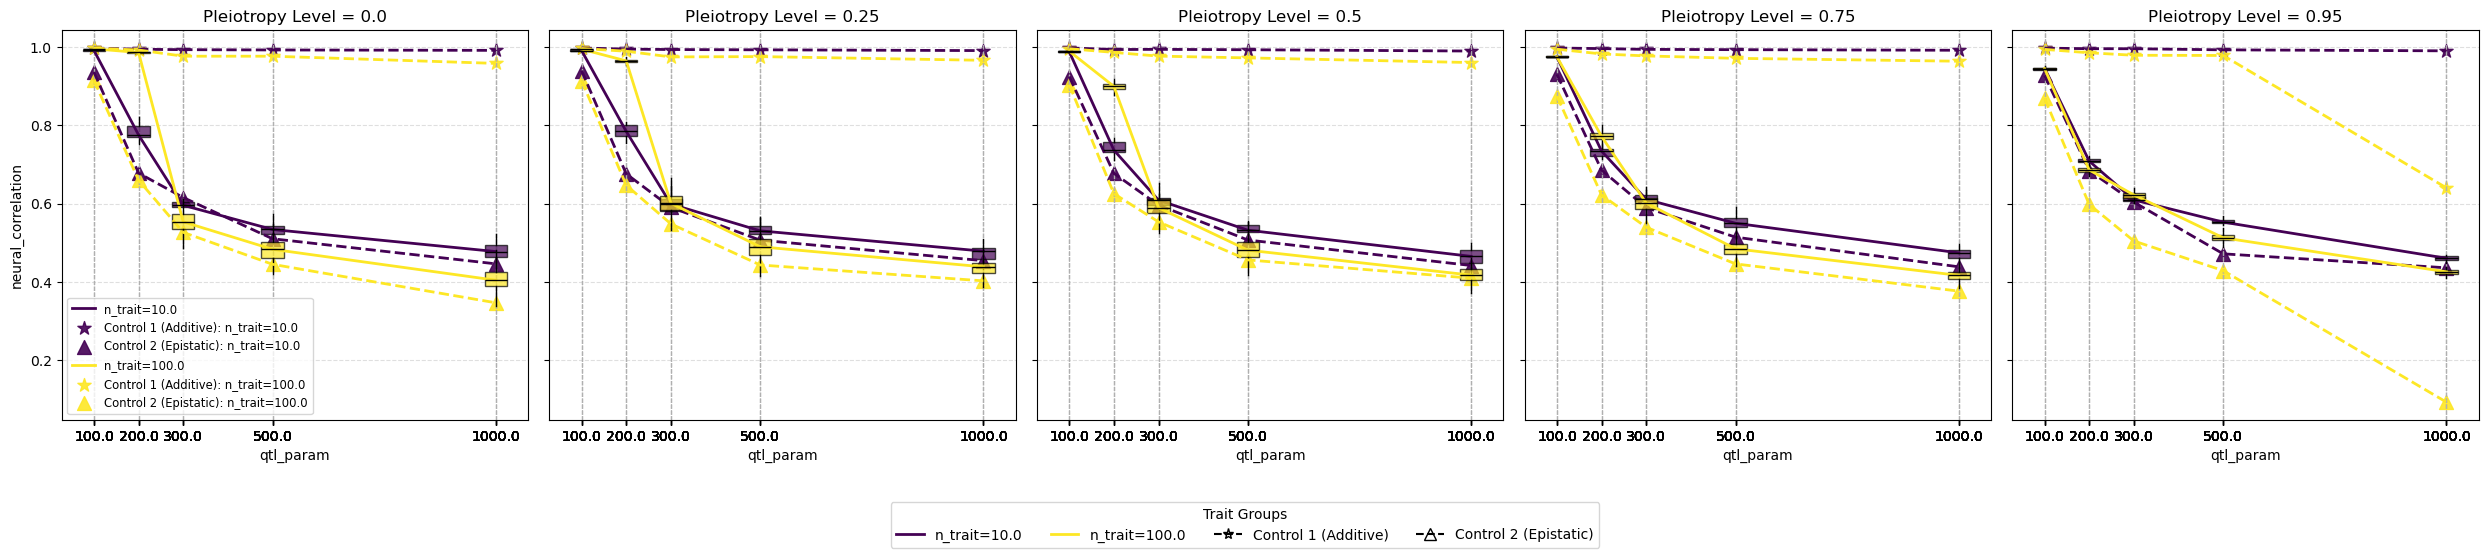

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your already properly formatted DataFrame

# Get unique pleio values and sort them
pleio_values = sorted(df['pleio'].unique())

# Create a figure with subplots in one row
fig, axes = plt.subplots(1, len(pleio_values), figsize=(5*len(pleio_values), 5),
                         sharex=True, sharey=True)

# Create color map for n_trait groups
unique_n_traits = sorted(df['n_trait'].unique())
n_trait_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_n_traits)))
n_trait_color_map = dict(zip(unique_n_traits, n_trait_colors))

# Control traits
control_traits = [1, 2]  # Traits 1 and 2 are control traits
control_names = {1: "Additive", 2: "Epistatic"}
control_markers = {1: "*", 2: "^"}  # Different markers for each control type

# Create each subplot
for i, pleio_val in enumerate(pleio_values):
    # Filter data for this pleio value
    subset = df[df['pleio'] == pleio_val]

    # Handle case where there's only one subplot
    if len(pleio_values) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Plot boxplots for experimental traits grouped by n_trait and qtl_param
    for n_trait, group in subset.groupby('n_trait'):
        # Filter out control traits from this group for boxplots
        exp_group = group[~group['trait_number'].isin(control_traits)]

        if not exp_group.empty:
            # Get unique qtl_param values
            qtl_params = sorted(exp_group['qtl_param'].unique())

            # For each qtl_param, create boxplot data
            boxplot_data = []
            positions = []

            for j, qtl in enumerate(qtl_params):
                # Get neural correlations for this qtl_param
                values = exp_group[exp_group['qtl_param'] == qtl]['neural_correlation'].values
                if len(values) > 0:
                    boxplot_data.append(values)
                    positions.append(qtl)

            # Create boxplots at the exact qtl_param positions
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.05*max(positions),
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on n_trait
                for patch in bplot['boxes']:
                    patch.set(facecolor=n_trait_color_map[n_trait], alpha=0.7)

            # Calculate median values for connecting lines
            medians = []
            for j, qtl in enumerate(positions):
                medians.append(np.median(boxplot_data[j]))

            # Add connecting lines for the medians
            ax.plot(positions, medians, '-', color=n_trait_color_map[n_trait],
                    linewidth=2, label=f'n_trait={n_trait}')

            # Now plot the control traits for this n_trait with matching color
            for trait_num in control_traits:
                # Get control data for this trait_number and n_trait
                control_data = group[(group['trait_number'] == trait_num)]

                if not control_data.empty:
                    control_data = control_data.sort_values('qtl_param')

                    # Label only the first occurrence
                    if i == 0:
                        label = f"Control {trait_num} ({control_names[trait_num]}): n_trait={n_trait}"
                    else:
                        label = None

                    # Plot with matching n_trait color but distinct marker for control type
                    ax.scatter(control_data['qtl_param'], control_data['neural_correlation'],
                              color=n_trait_color_map[n_trait], marker=control_markers[trait_num],
                              s=100, alpha=0.9, label=label)

                    # Connect with dashed line
                    ax.plot(control_data['qtl_param'], control_data['neural_correlation'], '--',
                            color=n_trait_color_map[n_trait], linewidth=2)

    # Set titles and labels
    ax.set_title(f'Pleiotropy Level = {pleio_val}')
    ax.set_xlabel('qtl_param')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('neural_correlation')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.4)

    # Add legend to the first subplot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # Only show the legend if there are entries
        if handles:
            ax.legend(loc='lower left', fontsize='small')

# Add a legend for the n_trait groups
handles, labels = [], []
for n_trait in sorted(unique_n_traits):
    # Create custom legend entry
    handle = plt.Line2D([0], [0], color=n_trait_color_map[n_trait],
                        linewidth=2)
    handles.append(handle)
    labels.append(f'n_trait={n_trait}')

# Add control trait marker legend
for trait_num in control_traits:
    handle = plt.Line2D([0], [0], marker=control_markers[trait_num],
                      color='black', markersize=8, linestyle='--',
                      markerfacecolor='none')
    handles.append(handle)
    labels.append(f"Control {trait_num} ({control_names[trait_num]})")

# Add the legend for all groups at the bottom
fig.legend(handles, labels, title='Trait Groups',
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(unique_n_traits) + len(control_traits)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom


# Show the plot
plt.show()

# If you want to save the figure
# plt.savefig('correlation_boxplots_by_pleiotropy.png', dpi=300, bbox_inches='tight')